In [139]:
import torch
import timeit
import matplotlib
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from utils import generate_task_1, generate_task_2, visualize_manipulator, visualize_calibration
from assignments import dkt, dkt_vectorized, manipulator_loss, calibration_loss

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TASK 1.1 - Implement DKT (5 points)
First, you will implement a function that calculates: “Positions of all joints and the end-effector ($X$), given joints angles ($\omega$), link lengths ($\rho$) and base angle and distance from origin ($base$) ”. This function will later help you to find the joint angles needed to move the end effector to desired position. We will use SGD (Stochastic gradient descent) to find desired position of the end-effector.

In general, you can use arbitrary architecture such as a 100-degree polynomial, fully connected neural network, or deep convolutional network and train its parameters to predict positions observed on the real manipulator; however, it is advisable to exploit the knowledge of the underlying kinematic structure. This task is called the Direct Kinematic Task (DKT).

##### For this task implement `dkt()` and `manipulator_loss()` to get 5 points.


In [191]:
# Generate data for the task
NUMBER_OF_JOINTS = 10
omega, rho, base, x_goal = generate_task_1(NUMBER_OF_JOINTS)

# Save initial state for repeatability
with torch.no_grad():
    old_omega, old_rho = omega.clone(), rho.clone()

# Let's take a look at the data
print(f'Joint angles: {omega}')
print(f'Link lengths: {rho}')
print(f'Base angle and length: {base}')
print(f'Goal coordinates: {x_goal}')

# Plot the base with the goal and random manipulator position
X_rand = torch.cat((torch.zeros(2).unsqueeze(1), torch.rand((2, NUMBER_OF_JOINTS))), 1)
visualize_manipulator(X_rand, x_goal)

## Direct Kinematic Task

Our inputs are 3 vectors. First is $\omega$ which represents relative angle of the joints. Second is $\rho$ which represents length of the links. The third is *base* which represents $[\omega_0 \quad \rho_0]$ with respect to origin.
$$
\omega = \begin{bmatrix} \omega_1 \\ \omega_2 \\ \vdots \\ \omega_n \end{bmatrix}, \quad
\rho = \begin{bmatrix} \rho_1 \\ \rho_2 \\ \vdots \\ \rho_n \end{bmatrix}, \quad
base = \begin{bmatrix} \omega_0 \\ \rho_0 \end{bmatrix}
$$

<br/>
<img src="images/dkt.png" width=660 height=336 align="center"/>
<br/>

We can calculate the joint positions using equations

$$
\varphi_k = \omega_0 + \omega_1 + \omega_2 + \dots + \omega_k \\
x_{k+1} = f_1(x_k,\;\rho_k,\;\varphi_k) \\
y_{k+1} = f_2(y_k,\;\rho_k,\;\varphi_k) \\
$$

After you implement functions $f_1$ and $f_2$ the output is

$$
X = \begin{bmatrix} x_0 & x_1 & \dots & x_n \\ y_0 & y_1 & \dots & y_n \end{bmatrix}
$$

In [1]:
# Change matplotlib backend for animation
import matplotlib
# matplotlib.use('Qt5Agg')

# Gradient requirement for optimization
omega.requires_grad_(True)
# rho.requires_grad_(True)

# Parameters (PLAY WITH THEM!!!)
# ------------- PLAY TIME -------------
learning_rate = 0.0005
n_iterations = 300
# -------------------------------------

optimizer = optim.SGD([omega, rho], lr=learning_rate)

for i in range(n_iterations):

    # Compute positions of the joints
    #----------------------------------------------------------
    # TODO: implement dkt function
    X = dkt(omega, rho, base)
    #----------------------------------------------------------

    # Compute loss
    #----------------------------------------------------------
    # TODO: implement manipulator_loss function
    loss = manipulator_loss(X, x_goal)
    #----------------------------------------------------------

    # Compute gradient
    loss.backward()
#
    # Make an optimization step and reset the gradient
    optimizer.step()
    optimizer.zero_grad()

    print(f'Iteration: {i}, loss = {loss.detach().numpy()}, rho (link lengths) = {rho.detach().numpy()}')
    if i % 5 == 0:
        visualize_manipulator(X, x_goal)

# Reset omega and rho for repeatability
with torch.no_grad():
    omega, rho = old_omega.clone(), old_rho.clone()

%matplotlib inline
# Change matplotlib backend back to inline

NameError: name 'omega' is not defined

In [94]:
X_2 = dkt_vectorized(omega, rho, base)

tensor([0.9579, 0.9579, 0.9579, 0.9579, 0.9579, 0.9579, 0.9579, 0.9579, 0.9579,
        0.9579, 0.9579, 0.2872, 0.2872, 0.2872, 0.2872, 0.2872, 0.2872, 0.2872,
        0.2872, 0.2872, 0.2872, 0.2872])


# TASK 1.2 - Implement vectorized DKT (1 point)

Now you will implement fully vectorized DKT with no `for` loop. Why? Because vectorized operations in numpy and pytorch are a lot faster than normal iterations. Don't you believe? Try it yourself! :D

##### For this task implement `dkt_vectorized()` to get 1 point.

## DKT Vectorized

Our inputs are three vectors. First is $\omega$ which represents relative angles of the joints. Second is $\rho$ which represents lengths of the links. Third is $base$ which represents base angle and distance from origin ([0, 0]). Let's take an example when we have 3 joints.
$$
\omega = \begin{bmatrix} \omega_1 \\ \omega_2 \end{bmatrix}, \quad
\rho = \begin{bmatrix} \rho_1 \\ \rho_2 \end{bmatrix}, \quad
base = \begin{bmatrix} \omega_0 \\ \rho_0 \end{bmatrix}
$$

First we can calculate total angle of each joint by equation $\varphi_k = \omega_1 + \omega_2 + \dots + \omega_k$. In our 3 joint case we can write the equation as follows.
$$
\begin{bmatrix} 1 & 0 & 0 \\ 1 & 1 & 0 \\ 1 & 1 & 1 \end{bmatrix}
\cdot
\begin{bmatrix} \omega_0 \\ \omega_1 \\ \omega_2 \end{bmatrix}
=
\begin{bmatrix} \omega_0 \\ \omega_0 + \omega_1 \\ \omega_0 + \omega_1 + \omega_2 \end{bmatrix}
=
\begin{bmatrix} \varphi_0 \\ \varphi_1 \\ \varphi_2 \end{bmatrix}\\
$$

Then we calculate the position of joints with respect to origin $[0 \quad 0]$.

$$
\begin{bmatrix}
    \cos{\varphi_0} & \cos{\varphi_1} & \cos{\varphi_2} \\
    \sin{\varphi_0} & \sin{\varphi_1} & \sin{\varphi_2}
\end{bmatrix}
\cdot
\begin{bmatrix}
    \rho_0 & 0 & 0 \\ 0 & \rho_1 & 0 \\ 0 & 0 & \rho_2
\end{bmatrix}
= \\
\begin{bmatrix}
    \rho_0 \cdot \cos{\varphi_0} & \rho_1 \cdot \cos{\varphi_1} & \rho_2 \cdot \cos{\varphi_2} \\
    \rho_0 \cdot \sin{\varphi_0} & \rho_1 \cdot \sin{\varphi_1} & \rho_2 \cdot \sin{\varphi_2}
\end{bmatrix}
=
\begin{bmatrix} x_0' & x_1' & x_3' \\ y_0' & y_1' & y_3' \end{bmatrix}
$$

And finally we can calculate the real position of the joints.

$$
\begin{bmatrix} x_0' & x_1' & x_3' \\ y_0' & y_1' & y_3' \end{bmatrix}
\cdot
\begin{bmatrix} 1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & 1 \end{bmatrix}
=
\begin{bmatrix} x_0 & x_1 & x_3 \\ y_0 & y_1 & y_3 \end{bmatrix}
= X
$$

In [100]:
# Generate data for the task
NUMBER_OF_JOINTS = 100
omega, rho, base, x_goal = generate_task_1(NUMBER_OF_JOINTS)

# Compute the positions
X_1 = dkt(omega, rho, base)
#----------------------------------------------------------
# TODO: implement dkt function
X_2 = dkt_vectorized(omega, rho, base)
#----------------------------------------------------------


# Compare the results
if torch.sum(torch.abs(X_2 - X_1)) < 1e-1:
    print("\nNicely done! Your vectorized and non-vectorized function matches.")

    print("\nTesting execution time of non-vectorized dkt...")
    %timeit dkt(omega, rho, base)

    print("\nTesting execution time of vectorized dkt...")
    %timeit dkt_vectorized(omega, rho, base)
    print("\nMaybe the difference is not that significant in this example, but you get the idea, right? :D")
else:
    print("Try harder!")



Nicely done! Your vectorized and non-vectorized function matches.

Testing execution time of non-vectorized dkt...
1.62 ms ± 7.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Testing execution time of vectorized dkt...
180 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Maybe the difference is not that significant in this example, but you get the idea, right? :D


# TASK 2 - Calibration (1 point)
Given the recorded positions of the end-effector ($X_{goals}$) and corresponding joint angles ($\omega$), estimate the lengths of all links ($\rho$). Simply define a new loss function (`loss_calibration()`) which measures the distance between the desired position of end-effector ($X_{goals}$) and the actual position for given ($\omega$) computed via `dkt()`.

##### For this task implement `calibration_loss()` to get 1 point.

Joint angles shape: torch.Size([5, 60])
Link lengths shape: torch.Size([5])
Base angle and length shape: torch.Size([2])
Goal coordinates shape: torch.Size([2, 60])


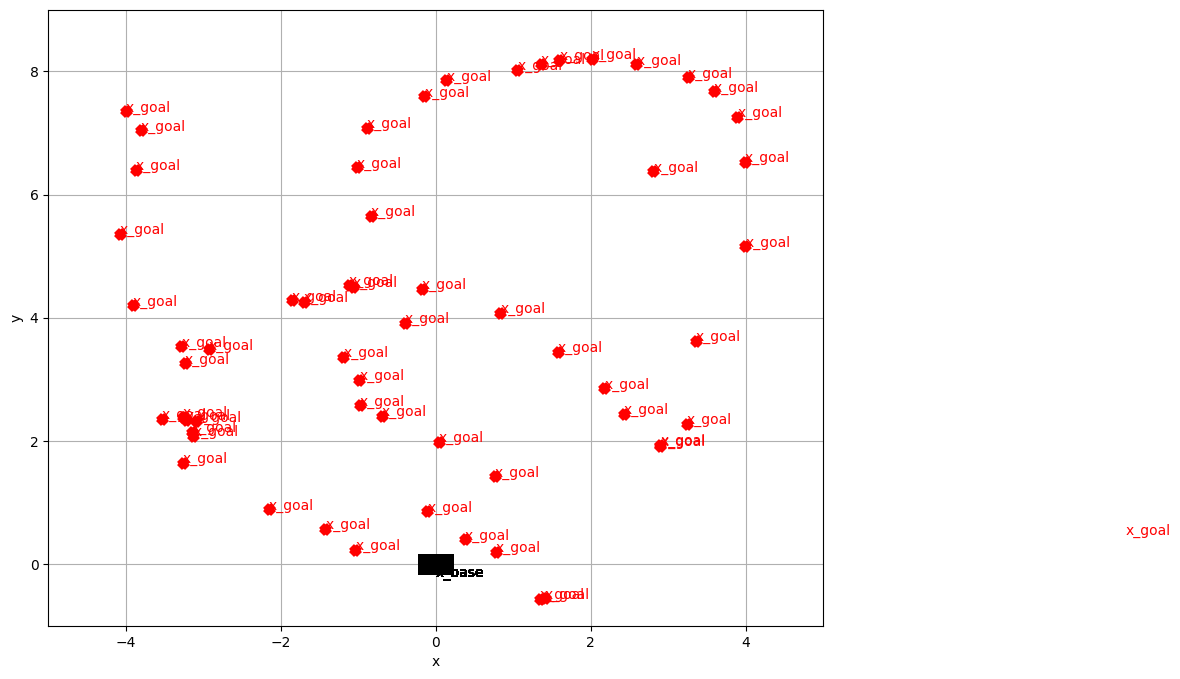

In [182]:
%matplotlib inline
# Generate data for the task
omega, rho, base, X_goals = generate_task_2()

with torch.no_grad():
    old_omega, old_rho = omega.clone(), rho.clone()

# Let's take a look at the data
print(f'Joint angles shape: {omega.shape}')
print(f'Link lengths shape: {rho.shape}')
print(f'Base angle and length shape: {base.shape}')
print(f'Goal coordinates shape: {X_goals.shape}')

# Plot the base with the goal and random manipulator position
states_zero = torch.zeros((X_goals.shape[1], 2, NUMBER_OF_JOINTS + 1))
visualize_calibration(states_zero, X_goals)

In [183]:
calibration_loss(X, X_goals[:, 0])

tensor(19.8641, dtype=torch.float64, grad_fn=<SumBackward0>)

In [195]:
# Change matplotlib backend for animation
import matplotlib
# matplotlib.use('Qt5Agg')

rho.requires_grad_(True)

# Parameters (PLAY WITH THEM!!!)
# ------------- PLAY TIME -------------
learning_rate = 0.001
n_iterations = 401
# learning_rate = 0.00008
# n_iterations = 40
# -------------------------------------

optimizer = optim.SGD([rho], lr=learning_rate)

n_measurements = X_goals.shape[1]

for i in range(n_iterations):
    loss = 0
    states = []
    for j in range(n_measurements):

        # Compute state of j-th state with optimized rho values and add it to states for visualization
        X = dkt(omega[:, j], rho, base)
        states.append(X)

        # Compute loss and add it to total loss for all measurements
        #----------------------------------------------------------
        # TODO: implement calibration_loss function
        loss += calibration_loss(X, X_goals[:, j])
        #----------------------------------------------------------

    # Compute gradient
    loss.backward()

    # Make an optimization step and reset the gradient
    optimizer.step()
    optimizer.zero_grad()

    # Print loss and visualize states
    print(f'Iteration: {i}, loss = {loss.detach().numpy()}, rho (link lengths) = {rho.detach().numpy()}')
    # if i % 50 == 0:
        # print(f'Iteration: {i}, loss = {loss.detach().numpy()}, rho (link lengths) = {rho.detach().numpy()}')

    if i % 25 == 0:
        print(f'Iteration: {i}, loss = {loss.detach().numpy()}, rho (link lengths) = {rho.detach().numpy()}')
        states = torch.stack(states, dim=0)
        visualize_calibration(states, X_goals)

# Reset omega and rho for repeatability
with torch.no_grad():
    omega, rho = old_omega.clone(), old_rho.clone()

# Change matplotlib backend back to inline
%matplotlib inline